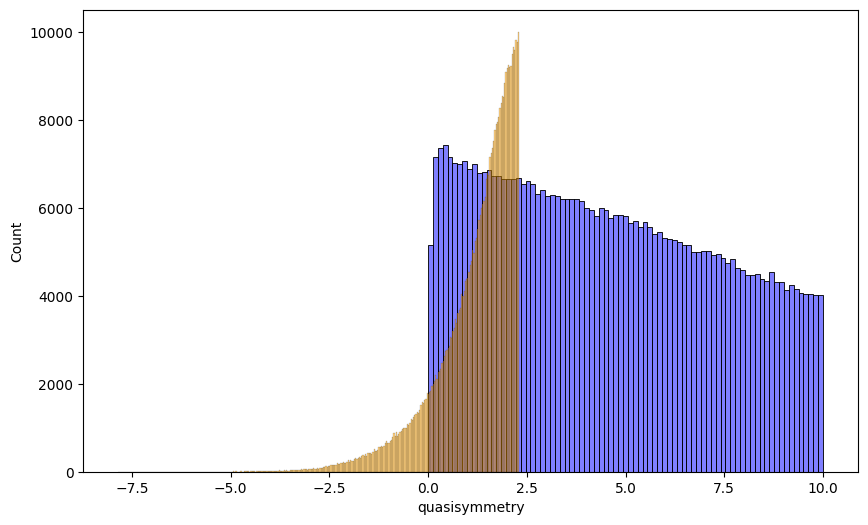

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sqlite3

# Load the true positive predictions from the CSV file
conn = sqlite3.connect('../../../../data/nfp2/nfp2_combined.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators_combined"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasisymmetry'])


X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = np.log(data_df_clean['quasisymmetry'])


#plot the distribution with and without log
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data_df_clean['quasisymmetry'], color="blue", alpha=0.5, label="Original")
sns.histplot(Y, color="orange", alpha=0.5, label="Log-transformed") 

# Split the data into training and testing sets
features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
best_params_manual = {
    'boosting_type': 'dart',
    'max_depth': 112,
    'num_leaves': 1665,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.996279867530332,
    'learning_rate': 0.19209584533276572,
    'num_iterations': 2853,
    'data_sample_strategy': 'bagging',
    'max_bins': 4062,
    'tree_learner': 'feature'
}

# Create and train the LightGBM model with the manually defined best parameters
model = lgb.LGBMRegressor(**best_params_manual)

# Assuming features_no_outliers and target_no_outliers are your feature matrix and target vector, respectively
model.fit(features_no_outliers, target_no_outliers)

import matplotlib.pyplot as plt
import seaborn as sns

/home/exouser/.local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.996279867530332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996279867530332
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.996279867530332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996279867530332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32496
[LightGBM] [Info] Number of data points in the train set: 365900, number of used features: 8
[LightGBM] [Info] Start training from score 1.177603


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.996279867530332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996279867530332
Test MSE: 0.2964110894743921
Test MAE: 0.3432964331617646
Test R^2: 0.7056074587666055
Predicted: -0.10362800724956277, Actual: 0.3204004167233618
Predicted: -0.17285681886354695, Actual: -0.7769137815166266
Predicted: -1.4987782585014837, Actual: -1.5703499844923836
Predicted: -0.043600835176494025, Actual: -1.082038314806294
Predicted: -0.21271599064266625, Actual: -4.338140798689651
Predicted: -0.11620983161953005, Actual: 0.07189961614724905
Predicted: -0.3799081081650107, Actual: -0.8722868433021699
Predicted: -0.4001214871149036, Actual: -0.6058325642754109
Predicted: -1.440658869531857, Actual: -2.4970290971824456
Predicted: -0.2408030129941539, Actual: -1.6502929712149423
Predicted: -0.2782488622867486, Actua

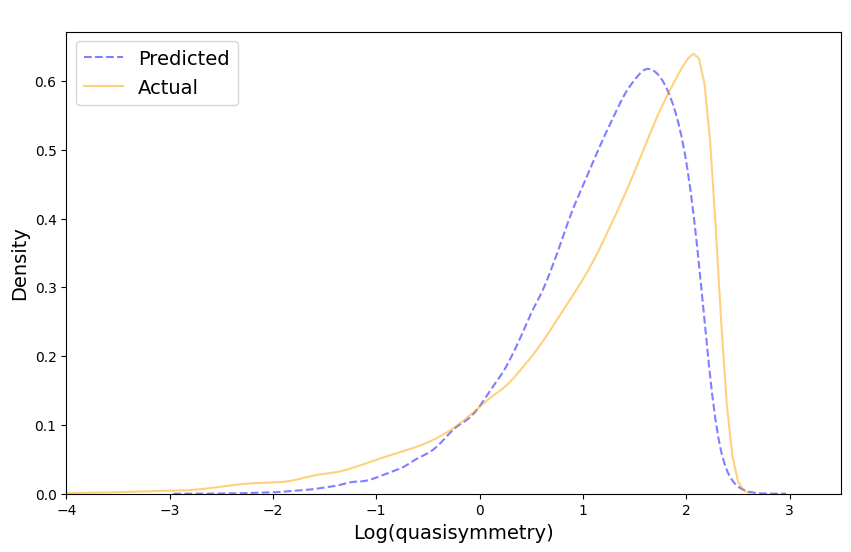

In [3]:
predictions = model.predict(test_features_no_outliers)

mse = mean_squared_error(test_target_no_outliers, predictions)
mae = mean_absolute_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")

for i in range(len(predictions)):
    if predictions[i] < 0:
        print(f"Predicted: {predictions[i]}, Actual: {test_target_no_outliers.iloc[i]}")

# Save predictions to a CSV file
predictions_df = pd.DataFrame(predictions, columns=["Predicted"])
predictions_df.to_csv("lightgbm_predictions.csv", index=False)
print("Predictions saved to lightgbm_predictions.csv")

# Combine and plot
#df_combined = pd.concat([df_predictions, df_actual])
print(predictions.shape)
print(test_target_no_outliers.shape)

plt.figure(figsize=(10, 6))
sns.kdeplot(predictions, fill=False, color="blue", alpha=0.5, label="Predicted", linestyle='--')
sns.kdeplot(test_target_no_outliers, fill=False, color="orange", alpha=0.5, label="Actual")
plt.title('  ')
plt.xlabel('Log(quasisymmetry)', fontsize = 14)
plt.xlim(-4, 3.5)
plt.ylabel('Density', fontsize = 14)
plt.legend(loc='upper left', fontsize= 14)
plt.savefig('actual_vs_predictedpdf.pdf')  
plt.show()

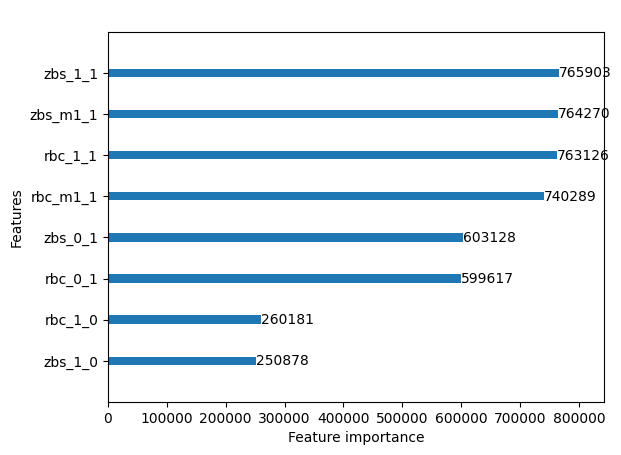

In [4]:
lgb.plot_importance(model, max_num_features=10, grid=False, importance_type= 'split')
plt.title('  ')
plt.savefig('feature_importance_lightgbm.pdf')  
plt.show()

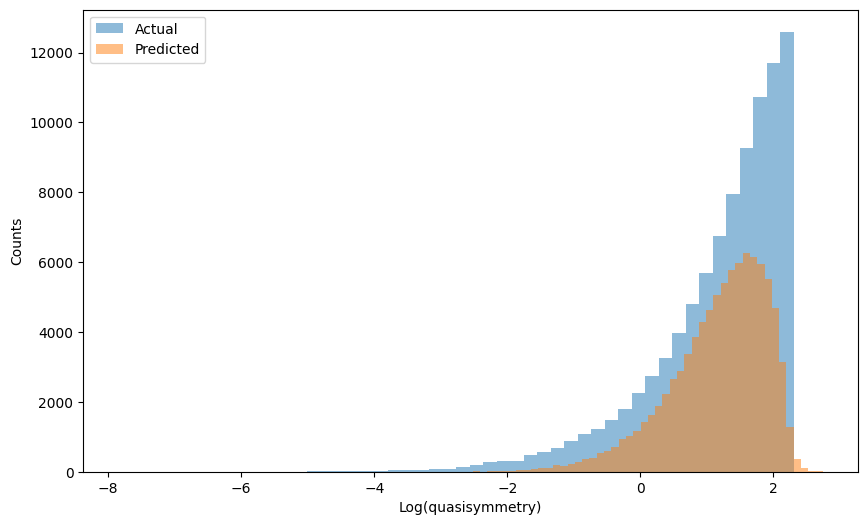

In [ ]:
plt.figure(figsize=(10, 6)) 
plt.hist(test_target_no_outliers, bins=50, alpha=0.5, label='Actual')
plt.hist(predictions, bins=50, alpha=0.5, label='Predicted')
plt.legend(loc='upper left')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Counts')
plt.show()


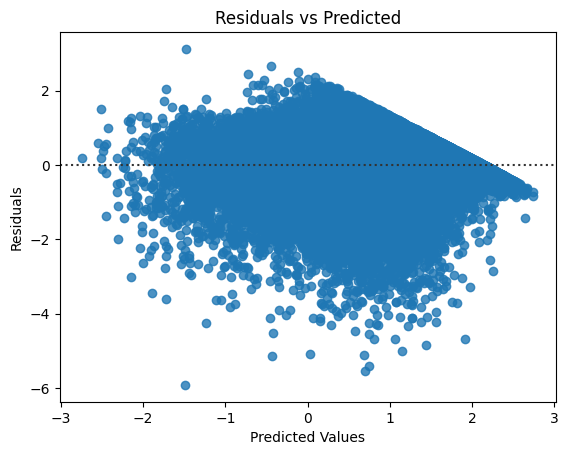

In [ ]:
import seaborn as sns

residuals = test_target_no_outliers - predictions
sns.residplot(x=predictions, y=residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [ ]:
# from sklearn.inspection import PartialDependenceDisplay


# features = ['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']  # Adjust with your feature names
# PartialDependenceDisplay.from_estimator(model, features_no_outliers, features)
# plt.suptitle('Partial Dependence Plots')
# plt.show()


In [ ]:
# plt.figure(figsize=(20, 10))
# ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'leaf_count'])
# plt.title('Tree Plot')
# plt.show()

In [ ]:
# feature = 'zbs_m1_1' # Replace with your feature name if different
# plt.figure(figsize=(10, 5))
# ax = lgb.plot_split_value_histogram(model, feature=feature, figsize=(10, 5))
# plt.title(f'Split Value Histogram for {feature}')
# plt.show()

Fitting of candidate distributions completed: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


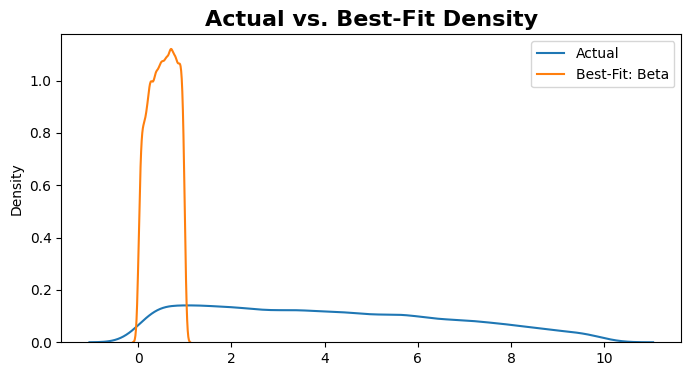

                nll      distribution
rank                                 
1        -24.950453              Beta
2       2826.197750            ZABeta
3      51691.402344         Expectile
4      54286.578673           Weibull
5      54808.518404  NegativeBinomial
6      54832.011705              ZINB
6      54832.011705              ZINB
8      54931.066406             Gamma
9      54954.550781           ZAGamma
10     55422.043972            Gumbel
11     55904.993578          Gaussian
12     55914.520898          StudentT
13     57002.665879           Poisson
14     58345.897631         LogNormal
15     58369.380369              ZALN
16     58458.710684           Laplace
17     61985.911710            Cauchy
18    284278.931047        SplineFlow


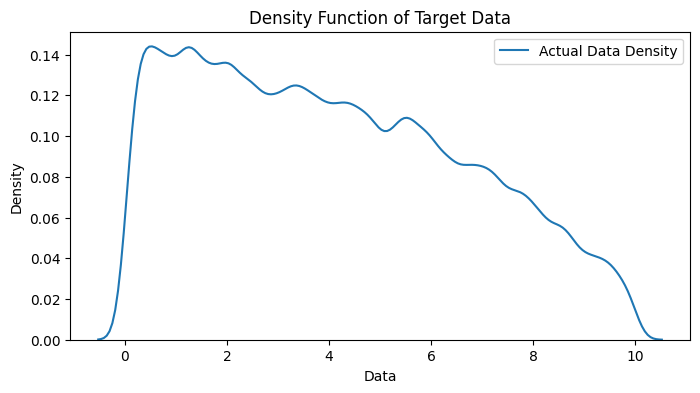

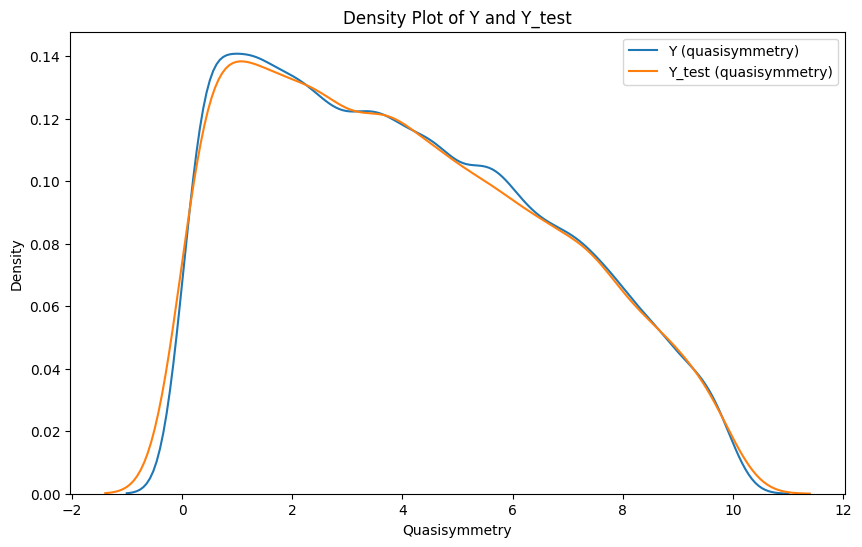

  0%|          | 0/1 [00:00<?, ?it/s]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  1
  Best trial:
    Value: 10542.577971461858
    Params: 
    max_depth: 18
    num_leaves: 5
    min_data_in_leaf: 129
    min_gain_to_split: 0.967985545750277
    min_sum_hessian_in_leaf: 7.548764540205035
    feature_fraction: 0.5961745220871226
    boosting_type: dart
    learning_rate: 0.13123181482690746
    max_delta_step: 0.3431780161508694
    num_boost_round: 231
    feature_pre_filter: False
    boosting: gbdt
    opt_rounds: 172
ewfre {'max_depth': 18, 'num_leaves': 5, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.967985545750277, 'min_sum_hessian_in_leaf': 7.548764540205035, 'feature_fraction': 0.5961745220871226, 'boosting_type': 'dart', 'learning_rate': 0.13123181482690746, 'max_delta_step': 0.3431780161508694, 'feature_pre_filter': False, 'boosting': 'gbdt', 'opt_rounds': 172}
nu, boost 231


In [ ]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np


# Load the true positive predictions from the CSV file
true_positive_predictions_file = 'true_positive_predictions_with_quasi.csv'
true_positive_data = pd.read_csv(true_positive_predictions_file)

# Separate features and target variable
X = true_positive_data[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = true_positive_data['quasisymmetry']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

target_no_outliers_np = np.array(Y_train)

# Initialize DistributionClass
lgblss_dist_class = DistributionClass()

# Define candidate distributions
candidate_distributions = [Beta, Cauchy, Expectile, Gamma, Gaussian, Gumbel, Laplace, LogNormal, NegativeBinomial, Poisson, SplineFlow, StudentT, Weibull, ZABeta, ZAGamma, ZALN, ZINB, ZINB]


# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=target_no_outliers_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
print(dist_nll)

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(target_no_outliers_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot the distribution of Y and Y_test
plt.figure(figsize=(10, 6))
sns.kdeplot(Y, label='Y (quasisymmetry)')
sns.kdeplot(Y_test, label='Y_test (quasisymmetry)')
plt.title('Density Plot of Y and Y_test')
plt.xlabel('Quasisymmetry')
plt.ylabel('Density')
plt.legend()
plt.show()


from lightgbmlss.model import LightGBMLSS
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np

# Select the first 1000 samples from X_train and their corresponding labels
X_train_subset = X_train
Y_train_subset = Y_train

# Create the Dataset with max_bin parameter specified
dtrain = lgb.Dataset(X_train_subset, label=Y_train_subset.values, params={'max_bin': 500})

# Initialize the LightGBMLSS model with the Weibull distribution
lgblss = LightGBMLSS(
    Weibull(stabilization="L2", response_fn="exp", loss_fn="nll")
)

# Define the parameter dictionary without max_bin
param_dict = {
    "max_depth": ["int", {"low": 1, "high": 25, "log": False}],
    "num_leaves": ["int", {"low": 2, "high": 100, "log": True}],
    "min_data_in_leaf": ["int", {"low": 20, "high": 500, "log": False}],
    "min_gain_to_split": ["float", {"low": 0.01, "high": 40, "log": True}],
    "min_sum_hessian_in_leaf": ["float", {"low": 0.01, "high": 100, "log": True}],
    #"subsample": ["float", {"low": 0.5, "high": 1.0, "log": False}],
    #"subsample_freq": ["int", {"low": 1, "high": 20, "log": False}],
    "feature_fraction": ["float", {"low": 0.3, "high": 1.0, "log": False}],
    "boosting_type": ["categorical", ["dart", "goss", "gbdt"]],
    "learning_rate": ["float", {"low": 0.1, "high": 0.2, "log": True}],
    # "lambda_l1" and "lambda_l2" are commented out as before
    "max_delta_step": ["float", {"low": 0, "high": 1, "log": False}],
    "num_boost_round": ["int", {"low": 5, "high": 1000, "log": True}],
    "feature_pre_filter": ["categorical", [False]],
}

# Set a seed for reproducibility
np.random.seed(123)

# Perform hyperparameter optimization
opt_param = lgblss.hyper_opt(
    param_dict,
    dtrain,
    #num_boost_round=30,
    nfold=5,
    early_stopping_rounds=50,
    max_minutes=403,
    n_trials=1,
    silence=True,
    seed=13,
    hp_seed=123
)

import numpy as np
import torch
from lightgbmlss.model import LightGBMLSS  # Ensure this import matches your actual usage

# Seed for reproducibility in numpy operations
np.random.seed(123)

# Assuming opt_param is defined somewhere in your code
opt_params = opt_param.copy()
n_rounds = opt_params['num_boost_round']
del opt_params['num_boost_round']

print('ewfre', opt_params)
print('nu, boost', n_rounds)

# Assuming dtrain is defined and is an appropriate dataset for training
# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Seed for reproducibility in torch operations
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = len(X_test)  # Use the number of rows in X_test as the number of samples

# Sample from predicted distribution
pred_samples = lgblss.predict(
    X_test,
    pred_type="samples",
    n_samples=n_samples,
    seed=123
)

# Return predicted distributional parameters
pred_params = lgblss.predict(
    X_test,
    pred_type="parameters"
)


